In [4]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays, u_met
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
import datetime
import glob
from GLOBAL import glob_util


coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (10., 10.)
%matplotlib inline

In [3]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [55]:
MREGIONS = {'WAf' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-8,-7,10,11], 'WAf'], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (1,5), (1,12), [21,24.5,-28,-24], 'SAf'], # 10
 'india_N' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [74,76,24,26], 'india'], # 7
 'india_S' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [76,79,18,21], 'india'], # 7
 'china_W' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [105,107,29,31], 'china'], # 4
 'china_E' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [111,113,25,27], 'china'], # 4
 'australia' : [[120,140,-23, -11], 'asia', 9, (10,12), (1,5), (1,12), [130,134, -21,-18], 'australia'], # 3
 'sub_SA' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-33,-30], 'sub_SA'] , # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17
 'GPlains_S' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-98,-95,36,39], 'GPlains'], # # 18
 'GPlains_N' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-99,-96,42,44], 'GPlains'] # # 18

}
S_REGION = 'sub_SA'
REGION = MREGIONS[S_REGION][7]

In [56]:
rdics = {}
for regs in MREGIONS.keys():
    bregs = MREGIONS[S_REGION][7]
    for ids, y in enumerate(range(2012,2020)):
        test = pd.read_csv('/media/ck/LStorage/global_water/save_files/'+bregs+'_initTime__mcs_tracks_extc_'+str(y)+'0101_'+str(y)+'1231.csv')
        if ids == 0:
            test2 = pd.DataFrame(test)
        else :
            test2 = pd.concat([test2, test])
    rdics[regs] = test2

In [57]:
tab = rdics[S_REGION]

In [58]:
#tab = pd.read_table(file, parse_dates=True, delimiter=',')

In [59]:
# test= tab[tab.time==tab.time[0]]
# test.com_lon.values

In [60]:
tab.keys()

Index(['length', 'mcs_length', 'mcs_type', 'starttrackresult',
       'endtrackresult', 'base_time', 'mcs_status', 'meanlat', 'meanlon',
       'core_area', 'ccs_area', 'mintb', 'meantb', 'ccs_meantb', 'core_meantb',
       'speed', 'direction1', 'direction-1', 'direction-2', 'direction0',
       'uspeed', 'vspeed', 'trackresult', 'cloudnumber', 'majoraxislength',
       'eccentricity', 'pf_length', 'pf_mcsstatus', 'pf_heavyrainratio',
       'total_rain', 'total_heavyrain', 'rainrate_heavyrain', 'npf',
       'pf_landfrac', 'pf_area1', 'pf_area2', 'pf_area3', 'pf_lon1', 'pf_lon2',
       'pf_lon3', 'pf_lat1', 'pf_lat2', 'pf_lat3', 'pf_rainrate1',
       'pf_rainrate2', 'pf_rainrate3', 'pf_maxrainrate1', 'pf_maxrainrate2',
       'pf_maxrainrate3', 'pf_accumrain1', 'pf_accumrain2', 'pf_accumrain3',
       'pf_accumrainheavy1', 'pf_accumrainheavy2', 'pf_accumrainheavy3',
       'pf_majoraxislength1', 'pf_majoraxislength2', 'pf_majoraxislength3',
       'pf_aspectratio1', 'pf_aspectratio

In [61]:
if tab[(tab['hour'] >= glob_util.LT_to_UTC_hour(16, REGION)) & (tab['hour'] <= glob_util.LT_to_UTC_hour(18, REGION))].size == 0:
    tab = tab[(tab['hour'] >= glob_util.LT_to_UTC_hour(16, REGION)) | (tab['hour'] <= glob_util.LT_to_UTC_hour(18, REGION))]
else:
    tab = tab[(tab['hour'] >= glob_util.LT_to_UTC_hour(16, REGION)) & (tab['hour'] <= glob_util.LT_to_UTC_hour(18, REGION))]

In [62]:
print(tab.meanlon.max(), tab.meanlon.min(), tab.meanlat.max(), tab.meanlat.min())

47.1718 -73.41938 -1.2112454 -59.2626


In [63]:
box = MREGIONS[S_REGION][6]
np.sum((tab.meanlon>box[0]) & (tab.meanlon<box[1]) & (tab.meanlat>box[2]) & (tab.meanlat<box[3]))

70

In [64]:
tab = tab.loc[(tab.meanlon>box[0]) & (tab.meanlon<box[1]) & (tab.meanlat>box[2]) & (tab.meanlat<box[3])]

In [65]:
lists = []
for row in tab.iterrows():
    #ipdb.set_trace()
    fdate = glob_util.UTC_to_LT_date(pd.to_datetime(row[1]['base_time']),  REGION)
    
    lists.append(datetime.datetime(fdate.year, fdate.month, fdate.day))
tab['lt_date'] = lists

In [66]:
np.unique(tab['lt_date']).size

35

In [67]:
np.unique(tab.hour)

array([20, 21, 22])

In [68]:
def run(shift):
    dic = {
    'q' : [],
    'qup' : [],
    't' : [],
    'u' : [],
    'v' : [],
    'w' : [],
    'u_orig' : [],
    'v_orig' : [],        
    'd' : [],
    't2' : [],
    'u10' : [],
    'v10' : [],
    'u10_orig' : [],
    'v10_orig' : [],
    'slp' : [],
    'cnt' : [],
    'cape' : [],
    'divMoist' : [],
    'ice' : [],
    'ice_orig' : [],
   # 'sh' : [],
    'rh' : [],
    'zshear' : [],
    #'theta' : [],
    'sh' : [],
    'lh' : [],
    }
    era5_files = cnst.lmcs_drive+ 'ERA5/hourly/' #cnst.ERA5 + 'hourly/
    af_pl = sorted(glob.glob(era5_files+'pressure_levels/'+REGION+'/'+'*.nc'))
    af_srfc = sorted(glob.glob(era5_files+'surface/'+REGION+'/'+'*.nc'))
    
    for date in tab['lt_date']:

        single = tab[tab['lt_date']==date]
        shour = 12

        lt_dt = pd.to_datetime(date)
        lt_dt = lt_dt.replace(hour=shour)
        dt = glob_util.LT_to_UTC_date(lt_dt, REGION)
        hour = dt.hour
        
        daystring = str(abs(shift))
        dayd = pd.Timedelta(daystring + 'days')
        if shift < 0:
            dt = dt - dayd
        if shift >=0:
            dt = dt + dayd
            
        window1 = dt - pd.Timedelta('10days')
        window2 = dt + pd.Timedelta('10days')
        

        fdate = '_' + str(dt.year) +'_' + str(dt.month).zfill(2) + '_' + str(dt.day).zfill(2)

        try:
            pl_file = era5_files + 'pressure_levels/'+REGION+'/ERA5' + fdate + '_'+REGION+'_pl.nc'
            srfc_file = era5_files + 'surface/'+REGION+'/ERA5' + fdate + '_'+REGION+'_srfc.nc'
          
            lsta = xr.open_dataset(pl_file) #sma  #'AMSR_L3_LPRMv05_A_'
            srfc = xr.open_dataset(srfc_file) #sma  #'AMSR_L3_LPRMv05_A_'

        except:
            #print('File missing', era5_files + 'pressure_levels/'+REGION+'/ERA5' + fdate + '_'+REGION+'_pl.nc')
            continue
            
        lsta = u_darrays.flip_lat(lsta)
        srfc = u_darrays.flip_lat(srfc)
        

        #lsta = lsta.sel(longitude=slice(-18, 0), latitude=slice(10,17))        
        #srfc = srfc.sel(longitude=slice(-18, 0), latitude=slice(10,17))

        
        try:
            lsta_low = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00', level=925)
        except:
            continue
        lsta_up = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00', level=650)
        
        srfc_low = srfc.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')

        fpl_pos = af_pl.index(pl_file)
        fsrfc_pos = af_srfc.index(srfc_file)
        
        pl_toread = np.array(af_pl)[fpl_pos-10:fpl_pos+10]
        srfc_toread = np.array(af_srfc)[fsrfc_pos-10:fsrfc_pos+10]
        
        lsta10 = xr.open_mfdataset(pl_toread)
        lsta10 = u_darrays.flip_lat(lsta10)
        lsta10 = lsta10.sel(time=lsta10['time.hour']==hour).load() #, longitude=slice(-18, 0), latitude=slice(10,17)).load()   


        lsta10_low = lsta10.sel(level=925) #time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                           #str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00')
        lsta10_up = lsta10.sel(level=650)

        print('Climlen', len(srfc_toread))
        srfc10 = xr.open_mfdataset(srfc_toread)
        srfc10 = u_darrays.flip_lat(srfc10)
        srfc10 = srfc10.sel(time=srfc10['time.hour']==hour).load() # , longitude=slice(-18, 0), latitude=slice(10,17)).load() 

        q = lsta_low['q'].squeeze()
        qup = lsta_up['q'].squeeze()
        u = lsta_up['u'].squeeze()
        v = lsta_up['v'].squeeze()
        w = lsta_low['w'].squeeze()
        t = lsta_low['t'].squeeze()
        d = lsta_low['d'].squeeze()
        rh = lsta_low['r'].squeeze()
        t2 = srfc_low['t2m'].squeeze()
        u100 = srfc_low['u10'].squeeze()
        v100 = srfc_low['v10'].squeeze()
        slp = srfc_low['sp'].squeeze()
        cape = srfc_low['cape'].squeeze()
        divMoist = srfc_low['p84.162'].squeeze()
        ice = srfc_low['tciw'].squeeze()
        sh = srfc_low['msshf'].squeeze()
        lh = srfc_low['mslhf'].squeeze()
       # sh = srfc_low['msshf'].squeeze()
        
        q_clim = lsta10_low['q'].squeeze().mean('time')
        qup_clim = lsta10_up['q'].squeeze().mean('time')
        u_clim = lsta10_up['u'].squeeze().mean('time')
        v_clim = lsta10_up['v'].squeeze().mean('time')
        w_clim = lsta10_low['w'].squeeze().mean('time')
        t_clim = lsta10_low['t'].squeeze().mean('time')
        rh_clim = lsta10_low['r'].squeeze().mean('time')
        d_clim = lsta10_low['d'].squeeze().mean('time')
        t2_clim = srfc10['t2m'].squeeze().mean('time')
        u100_clim = srfc10['u10'].squeeze().mean('time')
        v100_clim = srfc10['v10'].squeeze().mean('time')
        slp_clim = srfc10['sp'].squeeze().mean('time')
        cape_clim = srfc10['cape'].squeeze().mean('time')
        divMoist_clim = srfc10['p84.162'].squeeze().mean('time')
        ice_clim = srfc10['tciw'].squeeze().mean('time')
        sh_clim = srfc10['msshf'].squeeze().mean('time')
        lh_clim = srfc10['mslhf'].squeeze().mean('time')
   

        print('Doing '+ 'AMSR_' + str(dt.year) + str(dt.month).zfill(2) + str(
        dt.day).zfill(2) + '.nc')
    
        # theta_low = u_met.theta_e(925,lsta_low['t'].squeeze().values-273.15,lsta_low['q'].squeeze().values)
        # theta_high = u_met.theta_e(650,lsta_up['t'].squeeze().values-273.15,lsta_up['q'].squeeze().values)
        # thetadiff = (theta_low-theta_high).squeeze()
        
        # theta10_low = u_met.theta_e(925,lsta10_low['t'].squeeze().mean('time').values-273.15,lsta10_low['q'].squeeze().mean('time').values)
        # theta10_high = u_met.theta_e(650,lsta10_up['t'].squeeze().mean('time').values-273.15,lsta10_up['q'].squeeze().mean('time').values)
        # thetadiff10 = (theta10_low-theta10_high).squeeze()
        
        cnt = np.zeros_like(q.values)
        cnt[np.isfinite(q.values)] = 1

        dic['q'].append(q.values- q_clim.values)
        dic['qup'].append(qup.values- qup_clim.values)
        dic['v'].append(v.values- v_clim.values)
        dic['w'].append(w.values- w_clim.values)
        dic['u'].append(u.values- u_clim.values)
        dic['rh'].append(rh.values- rh_clim.values)
        dic['v_orig'].append(v.values)#
        dic['u_orig'].append(u.values)#
        dic['t'].append(t.values-t_clim.values)
        dic['d'].append(d.values-d_clim.values)
        dic['t2'].append(t2.values-t2_clim.values)
        dic['u10'].append(u100.values-u100_clim.values)
        dic['v10'].append(v100.values-v100_clim.values)
        dic['u10_orig'].append(u100.values)#
        dic['v10_orig'].append(v100.values)#
        dic['slp'].append(slp.values-slp_clim.values)
        dic['cape'].append(cape.values-cape_clim.values)#s-v100_clim.values)
        dic['divMoist'].append(divMoist.values-divMoist_clim.values)#-slp_clim.values)
        dic['ice'].append(ice.values-ice_clim.values)
        dic['ice_orig'].append(ice.values)
       # dic['sh'].append(sh.values-sh_clim.values)
#         ws, wd = u_met.u_v_to_ws_wd(u.values-u100.values, v.values-v100.values)
#         wsclim, wd = u_met.u_v_to_ws_wd(u_clim.values-u100_clim.values, v_clim.values-v100_clim.values)
        dic['zshear'].append((u.values-u100.values)-(u_clim.values-u100_clim.values)) #-wsclim
        #dic['theta'].append(thetadiff-thetadiff10)
        dic['cnt'].append(cnt)
        dic['sh'].append(sh.values-sh_clim.values)
        dic['lh'].append(lh.values-lh_clim.values)

        lat = lsta_low.latitude.values
        lon = lsta_low.longitude.values
        
        
    #ipdb.set_trace()
    for k in dic.keys():
        #print(k)
        dic[k] = np.nansum(np.stack(dic[k], axis=0), axis=0)

    return dic, lat, lon

In [69]:
def calc(dic):
    
    dics = {}
    for k in dic.keys():
        if k == 'cnt':
            continue
        dics[k] = dic[k] / dic['cnt']
    return dics

In [70]:
dic, lat, lon = run(0)

Climlen 20
Doing AMSR_20120220.nc
Climlen 20
Doing AMSR_20120220.nc
Climlen 20
Doing AMSR_20120220.nc
Climlen 20
Doing AMSR_20120918.nc
Climlen 20
Doing AMSR_20120918.nc
Climlen 20
Doing AMSR_20121128.nc
Climlen 20
Doing AMSR_20121128.nc
Climlen 20
Doing AMSR_20121128.nc
Climlen 20
Doing AMSR_20130124.nc
Climlen 20
Doing AMSR_20130124.nc
Climlen 20
Doing AMSR_20130124.nc
Climlen 20
Doing AMSR_20130201.nc
Climlen 20
Doing AMSR_20130201.nc
Climlen 20
Doing AMSR_20130201.nc
Climlen 20
Doing AMSR_20130331.nc
Climlen 20
Doing AMSR_20130331.nc
Climlen 20
Doing AMSR_20131011.nc
Climlen 20
Doing AMSR_20131011.nc
Climlen 20
Doing AMSR_20131228.nc
Climlen 20
Doing AMSR_20131228.nc
Climlen 20
Doing AMSR_20131228.nc
Climlen 20
Doing AMSR_20131230.nc
Climlen 20
Doing AMSR_20131230.nc
Climlen 20
Doing AMSR_20140110.nc
Climlen 20
Doing AMSR_20140211.nc
Climlen 20
Doing AMSR_20140211.nc
Climlen 20
Doing AMSR_20140211.nc
Climlen 20
Doing AMSR_20140217.nc
Climlen 20
Doing AMSR_20140217.nc
Climlen 20
Doi

In [71]:
dic['t2']/dic['cnt']

array([[-1.3031106 , -1.2923226 , -1.3039777 , ...,  0.49752808,
         0.52788436,  0.54276997],
       [-1.2828997 , -1.2340833 , -1.175875  , ...,  0.5050659 ,
         0.53583026,  0.5611455 ],
       [-1.0986712 , -1.084926  , -1.065908  , ...,  0.51390684,
         0.54200006,  0.5598585 ],
       ...,
       [ 0.07028721,  0.32913643,  0.29418293, ..., -0.12872009,
        -0.10671169, -0.21702488],
       [ 0.12649885,  0.34925842,  0.22220983, ..., -0.12383379,
        -0.07663487, -0.17537057],
       [ 0.17660522,  0.33503374,  0.21639927, ..., -0.16897321,
        -0.13111266, -0.17873448]], dtype=float32)

In [72]:
dic = calc(dic)

In [73]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap='RdBu', levels=levels, extend='both')
    ax.coastlines()

#     ## quiver list
#     if quiver is not None:
#         qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'], width=0.003, headwidth=3.2)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='k', linewidths=2 )
        plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='green',facecolor='none', zorder=99)
        
    ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('K')

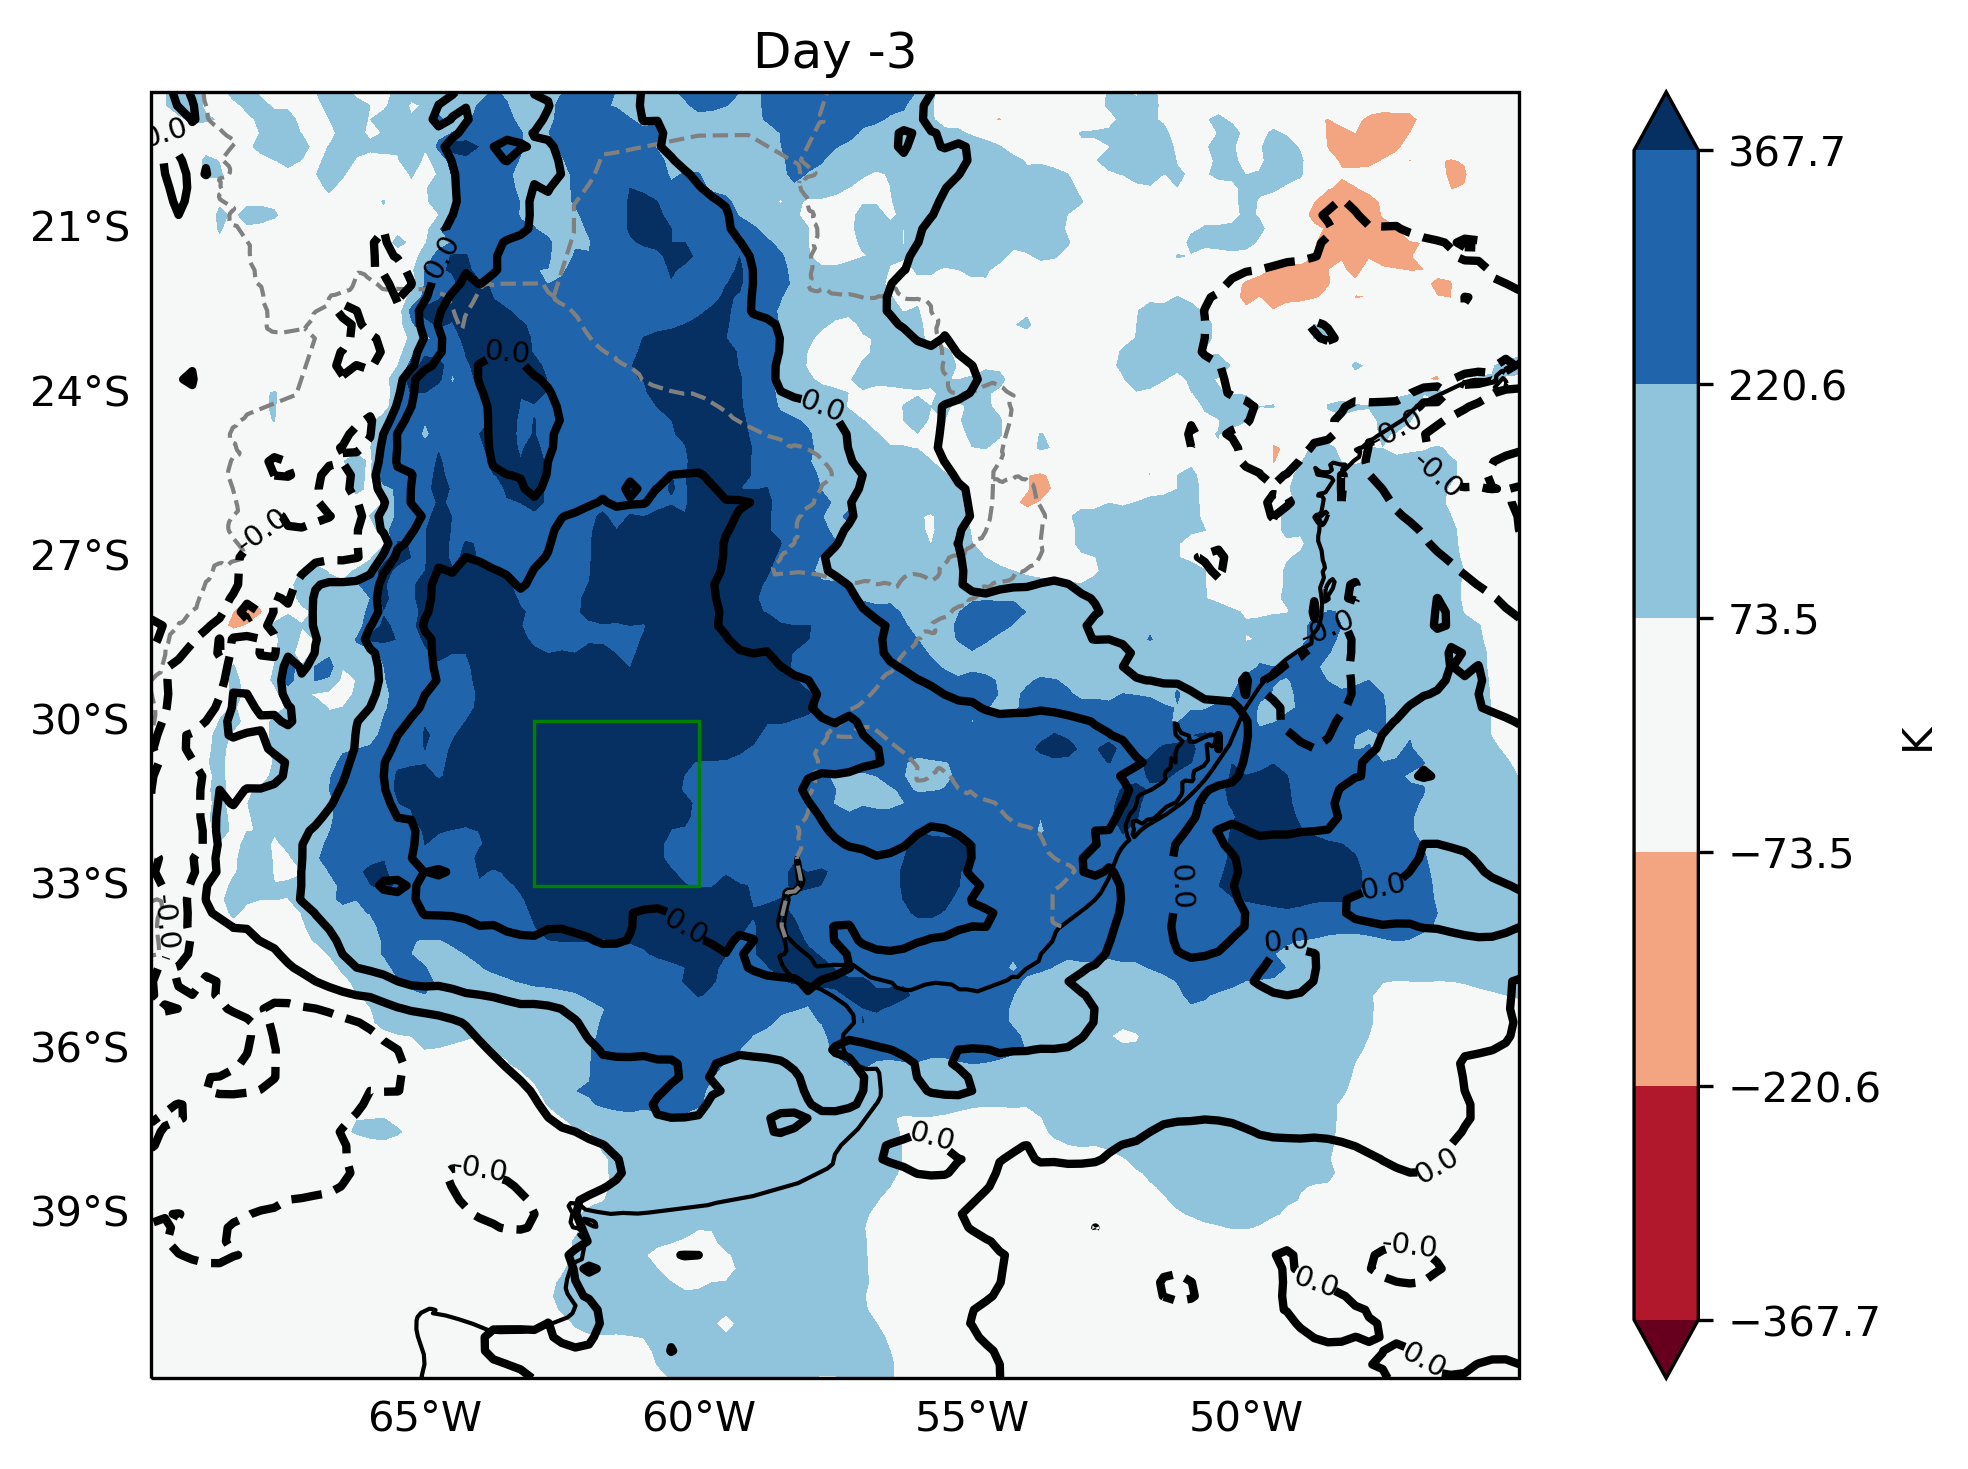

In [80]:
st=2
sarrow = 1
scale = 35
f = plt.figure(figsize=(8,5), dpi=300)

ax = f.add_subplot(111, projection=ccrs.PlateCarree())
lon2d, lat2d = np.meshgrid(lon,lat)
xquiv = lon2d[sarrow::st, sarrow::st]
yquiv = lat2d[sarrow::st, sarrow::st]


ws, wd = u_met.u_v_to_ws_wd(dic['u']-dic['u10'], dic['v']-dic['v10']) 

var = dic['cape']
u = dic['u10']
v = dic['t2']
cvar = 'q'
edge = np.max([np.abs(np.percentile(dic[cvar],10)),np.abs(np.percentile(dic[cvar],90))])
levs = np.linspace(edge*-1,edge,6)
contour = {'data' : dic[cvar], 'x': lon, 'y' : lat, 'levels' : levs}

edge = np.max([np.abs(np.percentile(var,10)),np.abs(np.percentile(var,90))])
lev = np.linspace(edge*-1,edge,6)

uu = u[sarrow::st, sarrow::st]
vv = v[sarrow::st, sarrow::st]
qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
draw_map(ax, var, lat, lon, title='Day -3',  quiver=qin, levels=lev, contour=contour)
f.canvas.draw()
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/NFLICS/plots/small_presi/NFLICS_single_t_slp_uv_1200.jpg')

In [ ]:
st=2
sarrow = 2
scale = 30
utag = 'u100'
vtag = 'v100'
f = plt.figure(figsize=(15,6), dpi=300)

for ids, num in enumerate([-2,-1,0,1,2,3]):

    ax = f.add_subplot(2,3,ids+1, projection=ccrs.PlateCarree())
    print(num)
    dic, lat, lon = run(num)
    dic = calc(dic)
    
    if ids == 0:
        lon2d, lat2d = np.meshgrid(lon,lat)
        xquiv = lon2d[sarrow::st, sarrow::st]
        yquiv = lat2d[sarrow::st, sarrow::st]
    #ipdb.set_trace()
    
    ws, wd = u_met.u_v_to_ws_wd(dic['u_orig']-dic['u100_orig'], dic['v_orig']-dic['v100_orig'])
    var = dic['ice']
    
    if ids == 0:
        edge = np.max([np.abs(np.percentile(var,1)),np.abs(np.percentile(var,99))])
        lev = np.linspace(edge*-1,edge,6) # edge*-1
    #ipdb.set_trace()
    u = dic[utag]
    v = dic[vtag]

    uu = u[sarrow::st, sarrow::st]
    vv = v[sarrow::st, sarrow::st]
    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
    
    
    cvar = 'q'
    invar = dic[cvar]*1000
    if ids == 0:
        edge = np.max([np.abs(np.percentile(invar,5)),np.abs(np.percentile(invar,95))])
        levs = np.linspace(edge*-1,edge,6) # edge*-1
    contour = {'data' : invar, 'x' : lon, 'y' : lat, 'levels' : levs}
    
    draw_map(ax, var, lat, lon, title='Day '+str(num),  quiver=qin, levels=lev, contour=contour)  #levels=lev,

f.canvas.draw()
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/NFLICS/plots/cb_same/NFLICS_ERA5anomaly_dakarstorms_large_ice_t2_uv10_anom_1200.jpg')

In [ ]:
st=2
sarrow = 2
scale = 40
utag = 'u100_orig'
vtag = 'v100_orig'
f = plt.figure(figsize=(15,5), dpi=300)

for ids, num in enumerate([-1,0]):

    ax = f.add_subplot(1,2,ids+1, projection=ccrs.PlateCarree())
    print(num)
    dic, lat, lon = run(num)
    dic = calc(dic)
    
    if ids == 0:
        lon2d, lat2d = np.meshgrid(lon,lat)
        xquiv = lon2d[sarrow::st, sarrow::st]
        yquiv = lat2d[sarrow::st, sarrow::st]
    #ipdb.set_trace()
    
    ws, wd = u_met.u_v_to_ws_wd(dic['u_orig']-dic['u100_orig'], dic['v_orig']-dic['v100_orig'])
    var = dic['slp']
    
    if ids == 0:
        edge = np.max([np.abs(np.percentile(var,5)),np.abs(np.percentile(var,95))])
        lev = np.linspace(edge*-1,edge,6) # edge*-1
    #ipdb.set_trace()
    u = dic[utag]
    v = dic[vtag]

    uu = u[sarrow::st, sarrow::st]
    vv = v[sarrow::st, sarrow::st]
    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
    
    
    cvar = 'v'
    invar = dic[cvar]
    if ids == 0:
        edge = np.max([np.abs(np.percentile(invar,20)),np.abs(np.percentile(invar,80))])
        levs = np.linspace(edge*-1,edge,6) # edge*-1
    contour = {'data' : invar, 'x' : lon, 'y' : lat, 'levels' : levs}
    
    draw_map(ax, var, lat, lon, title='Day '+str(num),  quiver=qin, levels=lev, contour=contour)  #levels=lev,

f.canvas.draw()
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/NFLICS/plots/small_presi/nine/NFLICS_ERA5anomaly_dakarstorms_large_slp_v_uv_orig_1200.jpg')

In [164]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap='RdBu', levels=levels, extend='both')
    ax.coastlines()

#     ## quiver list
#     if quiver is not None:
#         qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'], width=0.003, headwidth=3.2)
    
    
        ## additional contour on plot   
    contour=None
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='k', linewidths=2 )
        plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=1,edgecolor='green',facecolor='none', zorder=99)
        
    ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('g/kg')

In [165]:
box

[-8.5, -8, 12, 12.5]

## 

-1
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_10_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_10_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_08_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_13_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_21_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_20_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_30_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_30_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_30_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_leve

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


0
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_11_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_11_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_09_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_14_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_22_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_21_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_31_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_31_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_31_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_level

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


1
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_12_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_12_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_10_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_15_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_23_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_22_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_01_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_01_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_01_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_level

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_13_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_13_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_11_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_16_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_24_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_23_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_02_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_02_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_02_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


-1
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_10_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_10_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_08_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_13_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_21_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_20_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_30_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_30_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_30_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_leve

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_11_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_11_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_09_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_14_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_22_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_21_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_31_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_31_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_31_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_12_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_12_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_10_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_15_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_23_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_22_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_01_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_01_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_01_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


2
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_13_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_06_13_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_11_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_16_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_07_24_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_08_23_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_02_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_02_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_levels/WAf/ERA5_2000_09_02_WAf_pl.nc
File missing /media/ck/LStorage/global_water/ERA5/hourly/pressure_level

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


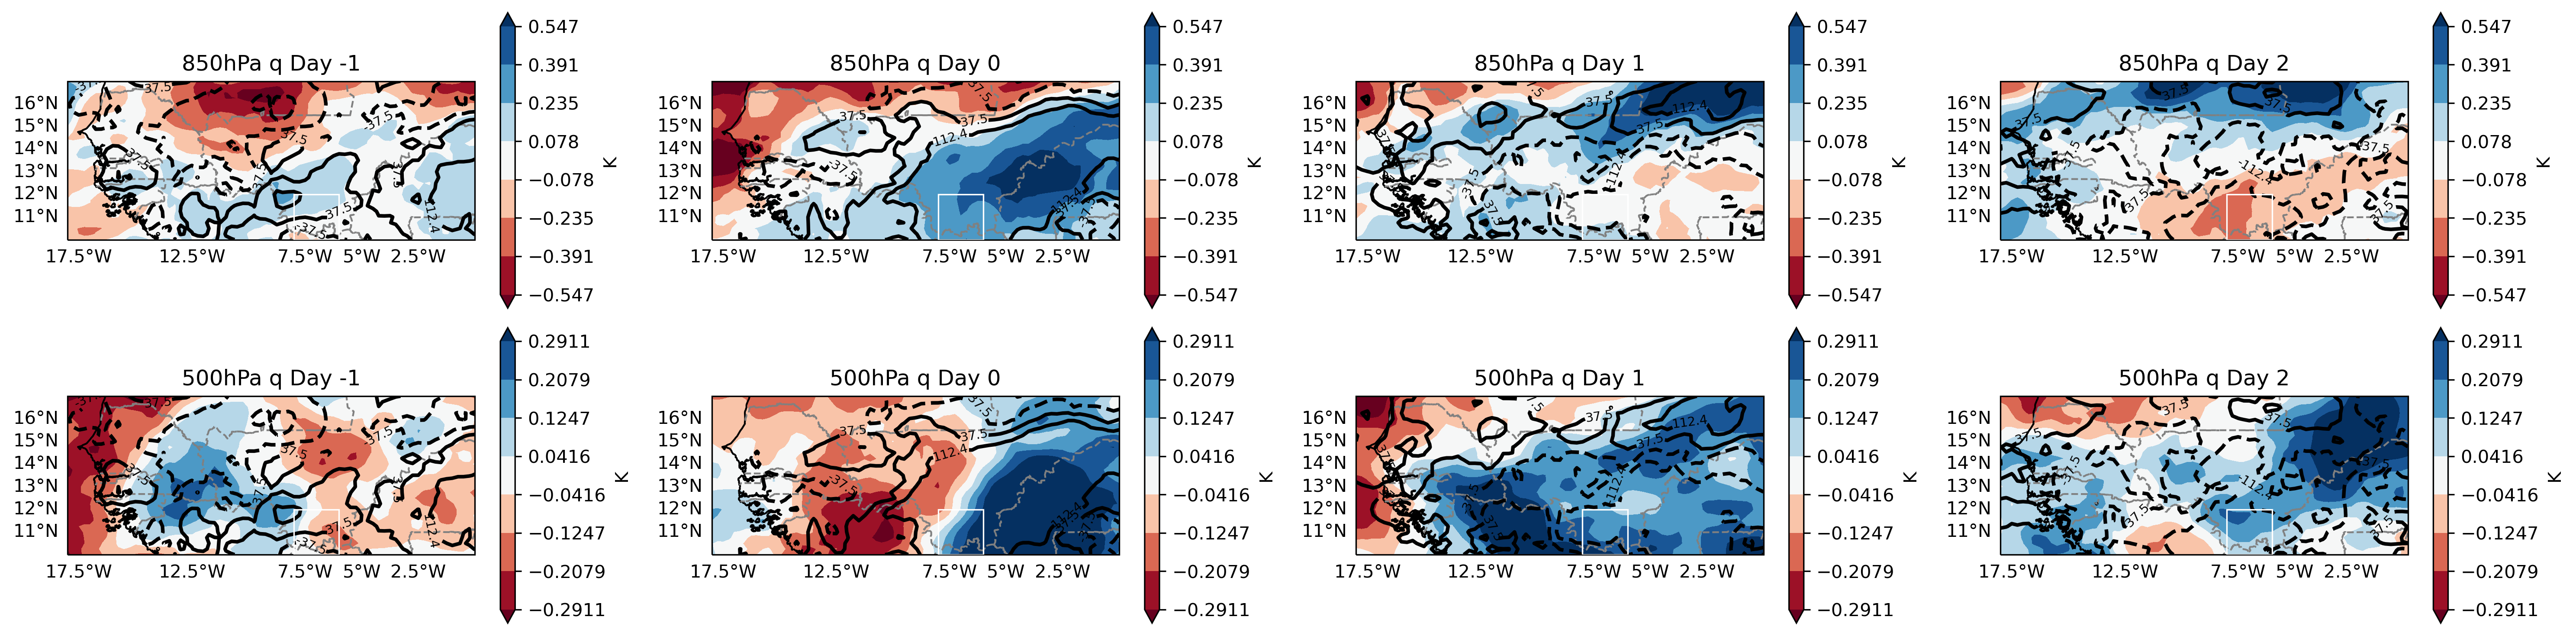

In [59]:
st=2
sarrow = 2
scale = 30
utag = 'u10'
vtag = 'v10'

f = plt.figure(figsize=(20,5), dpi=300)

for ids, num in enumerate([-1, 0,1,2]):

    ax = f.add_subplot(2,4,ids+1, projection=ccrs.PlateCarree())
    print(num)
    dic, lat, lon = run(num)
    dic = calc(dic)
    
    if ids == 0:
        lon2d, lat2d = np.meshgrid(lon,lat)
        xquiv = lon2d[sarrow::st, sarrow::st]
        yquiv = lat2d[sarrow::st, sarrow::st]
    #ipdb.set_trace()
    
    ws, wd = u_met.u_v_to_ws_wd(dic['u_orig']-dic['u10_orig'], dic['v_orig']-dic['v10_orig'])
    vart = 'q'
    var = dic[vart]*1000
    
    if ids == 0:
        edge = np.max([np.abs(np.percentile(var,1)),np.abs(np.percentile(var,99))])
        lev = np.linspace(edge*-1,edge,8) # edge*-1
    #ipdb.set_trace()
    u = dic[utag]
    v = dic[vtag]

    uu = u[sarrow::st, sarrow::st]
    vv = v[sarrow::st, sarrow::st]
    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
    
    
    if vart == 'q':
        vtags = '850hPa q'
    if vart == 'qup':
        vtags = '500hPa q'
    
    cvar = 'cape'
    invar = dic[cvar]
    if ids == 0:
        edge = np.max([np.abs(np.percentile(invar,5)),np.abs(np.percentile(invar,95))])
        levs = np.linspace(edge*-1,edge,4) # edge*-1
    contour = {'data' : invar, 'x' : lon, 'y' : lat, 'levels' : levs}
    
    draw_map(ax, var, lat, lon, title=vtags+' Day '+str(num),  quiver=qin, levels=lev, contour=contour)  #levels=lev,
    
    
for ids, num in enumerate([-1, 0,1,2]):
    

    ax = f.add_subplot(2,4,ids+1+4, projection=ccrs.PlateCarree())
    print(num)
    dic, lat, lon = run(num)
    dic = calc(dic)
    
    if ids == 0:
        lon2d, lat2d = np.meshgrid(lon,lat)
        xquiv = lon2d[sarrow::st, sarrow::st]
        yquiv = lat2d[sarrow::st, sarrow::st]
    #ipdb.set_trace()
    
    ws, wd = u_met.u_v_to_ws_wd(dic['u_orig']-dic['u10_orig'], dic['v_orig']-dic['v10_orig'])
    vart = 'qup'
    var = dic[vart]*1000
    
    if ids == 0:
        edge = np.max([np.abs(np.percentile(var,1)),np.abs(np.percentile(var,99))])
        lev = np.linspace(edge*-1,edge,8) # edge*-1
    #ipdb.set_trace()
    u = dic[utag]
    v = dic[vtag]

    uu = u[sarrow::st, sarrow::st]
    vv = v[sarrow::st, sarrow::st]
    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
    
    
    cvar = 'cape'
    invar = dic[cvar]
    if ids == 0:
        edge = np.max([np.abs(np.percentile(invar,5)),np.abs(np.percentile(invar,95))])
        levs = np.linspace(edge*-1,edge,4) # edge*-1
    contour = {'data' : invar, 'x' : lon, 'y' : lat, 'levels' : levs}
    
    if vart == 'q':
        vtags = '850hPa q'
    if vart == 'qup':
        vtags = '500hPa q'
    
    draw_map(ax, var, lat, lon, title=vtags+' Day '+str(num),  quiver=qin, levels=lev, contour=contour)  #levels=lev,

f.canvas.draw()
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/NFLICS/plots/cb_same/NFLICS_ERA5anomaly_dakarstorms_anom_qtest.jpg')

In [ ]:
#np.sum((tab.lon>-5) & (tab.lon<-4) & (tab.lat>12) & (tab.lat<15))

In [ ]:
#(tab.lon>-5.5) & (tab.lon<-5) & (tab.lat>12) & (tab.lat<12.5)